<a href="https://colab.research.google.com/github/zimzion/EYTIP/blob/master/class_0N_ROC_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import *
from sklearn.model_selection import train_test_split
import numpy as np
# Load datasetd
dataset = load_breast_cancer()
# Split data into train-test pools 
train, test, train_labels, test_labels = train_test_split(dataset['data'],
                                                          dataset['target'],
                                                          test_size=0.33)
# Train model 
logregr = LogisticRegression().fit(train, train_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
# Rename, listify 
actuals = list(test_labels)
# Predict probablities of test data [0,1]
scores = list(logregr.predict_proba(test)[:,1])

In [0]:
# Predict binary outcomes (0,1)
predictions = list(logregr.predict(test))
# Equivalently 
predictions = [1 if s>0.5 else 0 for s in scores]

In [4]:
print("Accuracy = %.3f" % (sum([p==a for p, a in zip(predictions, actuals)])/len(predictions)))

Accuracy = 0.910


In [0]:
plot_data = [(i, prob, actual) for i, (prob, actual) in enumerate(zip(scores, actuals))]
data_filter = lambda cate : filter(lambda x : x[2] == cate, plot_data)

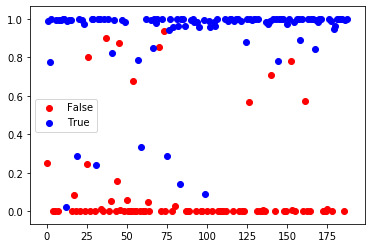

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
colors = ['r', 'b']
labels = ['False', 'True']

fig, ax = plt.subplots()
for i in set(test_labels):
  filtered_data = list(data_filter(i))
  x, y, _ = list(map(list, zip(*filtered_data)))
  ax.scatter(x, y, color=colors[i], label=labels[i])
ax.legend()
plt.show()

In [0]:
import collections
ConfusionMatrix = collections.namedtuple('conf', ['tp','fp','tn','fn']) 

def calc_ConfusionMatrix(actuals, scores, threshold=0.5, positive_label=1):
    tp=fp=tn=fn=0
    bool_actuals = [act==positive_label for act in actuals]
    for truth, score in zip(bool_actuals, scores):
        if score > threshold:                      # predicted positive 
            if truth:                              # actually positive 
                tp += 1
            else:                                  # actually negative              
                fp += 1          
        else:                                      # predicted negative 
            if not truth:                          # actually negative 
                tn += 1                          
            else:                                  # actually positive 
                fn += 1
    return ConfusionMatrix(tp, fp, tn, fn)

def ACC(conf_mtrx):
    return (conf_mtrx.tp + conf_mtrx.tn) / (conf_mtrx.fp + conf_mtrx.tn + conf_mtrx.tp + conf_mtrx.fn)

def FPR(conf_mtrx):
    return conf_mtrx.fp / (conf_mtrx.fp + conf_mtrx.tn) if (conf_mtrx.fp + conf_mtrx.tn)!=0 else 0

def TPR(conf_mtrx):
    return conf_mtrx.tp / (conf_mtrx.tp + conf_mtrx.fn) if (conf_mtrx.tp + conf_mtrx.fn)!=0 else 0

def apply(actuals, scores, **fxns):
    # generate thresholds over score domain 
    low = min(scores)
    high = max(scores)
    step = (abs(low) + abs(high)) / 1000
    thresholds = np.arange(low-step, high+step, step)
    # calculate confusion matrices for all thresholds
    confusionMatrices = []
    for threshold in thresholds:
        confusionMatrices.append(calc_ConfusionMatrix(actuals, scores, threshold))
    # apply functions to confusion matrices 
    results = {fname:list(map(fxn, confusionMatrices)) for fname, fxn in fxns.items()}
    results["THR"] = thresholds
    return results

In [0]:
acc = apply(actuals,  scores, ACC=ACC)

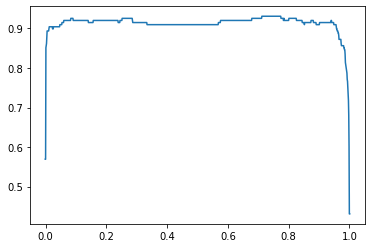

In [49]:
_, ax = plt.subplots()
ax.plot(acc['THR'], acc['ACC'])
plt.show()

In [0]:
def ROC(actuals, scores):
    return apply(actuals, scores, FPR=FPR, TPR=TPR)

roc = ROC(actuals, scores)

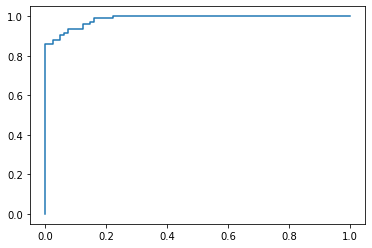

In [52]:
_, ax = plt.subplots()
ax.plot(roc['FPR'], roc['TPR'])
plt.show()

In [0]:
gd = list()
for i in set(train_labels):
  filtered_data = list(data_filter(i))
  _, y, _ = list(map(list, zip(*filtered_data)))
  m = np.mean(y)
  sd = np.std(y)
  gd.append((m, sd))

In [0]:
def pdf(x, std, mean):
    const = 1.0 / np.sqrt(2*np.pi*(std**2))
    pdf_normal_dist = const*np.exp(-((x-mean)**2)/(2.0*(std**2)))
    return pdf_normal_dist

In [56]:
print(gd)

[(0.10685477674263076, 0.2557305906714232), (0.9278174774575091, 0.19993857969440246)]


In [0]:
x = np.linspace(-1, 2, num=1000)
pdf_list = list()
for m, std in gd:
  pdf_dist = pdf(x, std, m)
  pdf_list.append(pdf_dist)

In [0]:
def plot_pdf(good_pdf, bad_pdf, ax):
    #good_pdf[0] = 0
    #good_pdf[-1] = 0
    #bad_pdf[0] = 0
    #bad_pdf[-1] = 0

    ax.fill(x, good_pdf, "g", alpha=0.5)
    ax.fill(x, bad_pdf,"r", alpha=0.5)
    ax.set_xlim([-1,2])
    ax.set_ylim([0,3])
    ax.set_title("Probability Distribution", fontsize=14)
    ax.set_ylabel('Counts', fontsize=12)
    ax.set_xlabel('P(X="bad")', fontsize=12)
    ax.legend(["good","bad"])

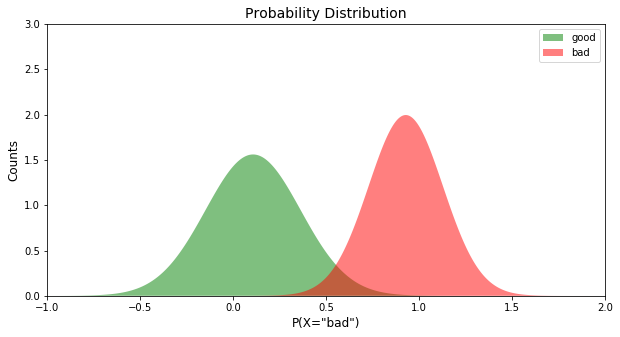

In [138]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
plot_pdf(pdf_list[0], pdf_list[1], ax)

In [0]:
cm = calc_ConfusionMatrix(actuals, scores, threshold=0.8)

In [130]:
cm

conf(tp=97, fp=5, tn=76, fn=10)

In [0]:
true_count = len(list(filter(lambda x : x == 1, test_labels)))
false_count = len(list(filter(lambda x : x == 0, test_labels)))

def get_conf_from_dist(threshold):
  fp = sum(prob for _, prob in filter(lambda x : x[0] >= threshold, zip(x, pdf_list[0]))) / false_count
  tn = sum(prob for _, prob in filter(lambda x : x[0] < threshold, zip(x, pdf_list[0]))) / false_count
  tp = sum(prob for _, prob in filter(lambda x : x[0] >= threshold, zip(x, pdf_list[1]))) / true_count
  fn = sum(prob for _, prob in filter(lambda x : x[0] < threshold, zip(x, pdf_list[1]))) / true_count
  return ConfusionMatrix(tp, fp, tn, fn)

In [0]:
cm_from_dist = get_conf_from_dist(0.8)

In [142]:
cm_from_dist

conf(tp=2.0657026258297964, fp=0.016155590737878936, tn=4.809896049484043, fn=0.7326165918092933)

In [143]:
ACC(cm)

0.9202127659574468

In [144]:
ACC(cm_from_dist)

0.9017922663382565